<a href="https://colab.research.google.com/github/NolanniLB/DS-Unit-1-Sprint-1-Data-Wrangling-and-Storytelling/blob/master/NolanniB_LS_DS_224_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](http://archive.is/DelgE), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [0]:
# taking care of imports
import numpy as np
from sklearn.metrics import accuracy_score,plot_confusion_matrix
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


In [0]:
# Split and clean the data
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['status_group'], random_state=42)
def wrangle(X):
   
    X = X.copy()
   
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    cols_with_zeros = ['longitude', 'latitude', 'construction_year', 
                       'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        X[col+'_MISSING'] = X[col].isnull()
    # Drop duplicate columns
    duplicates = ['quantity_group', 'payment_type', 'waterpoint_type_group', 'extraction_type_group']
    X = X.drop(columns=duplicates)
    # Drop recorded_by (never varies) and id (always varies, random)
    unusable_variance = ['recorded_by', 'id']
    X = X.drop(columns=unusable_variance)
    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    # Split Data from date_recorded, then drop the original column
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    # Engineer feature: how many years from construction_year to date_recorded
    X['years'] = X['year_recorded'] - X['construction_year']
    X['years_MISSING'] = X['years'].isnull()
    
    return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [7]:
# create target and features
target = 'status_group'
# a dataframe with all train columns except the target
train_features = train.drop(columns=target)
# Get a list of the numeric features
numeric_features = train.select_dtypes(include='number').columns.tolist()
# a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()
# list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()
# Combine the lists 
features = numeric_features + categorical_features

X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test

# create pipeline
pipeline = make_pipeline(
    ce.ordinal.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    StandardScaler(),
    RandomForestClassifier(n_estimators=100, n_jobs=-1,max_features='auto',random_state=42)
)

pipeline.fit(X_train, y_train)
print(f'Validation accuracy: {pipeline.score(X_val, y_val)}')

Validation accuracy: 0.811952861952862


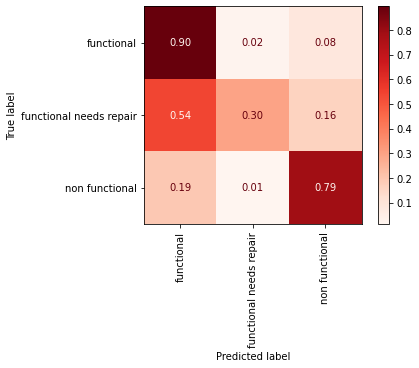

In [18]:
# plot the confusion matrix 
plot_confusion_matrix(pipeline, X_val, y_val,
                      normalize='true',
                      values_format='.2f',
                      xticks_rotation='vertical', cmap='Reds')

In [14]:
# Stretch goals
from scipy.stats import randint, uniform
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

param_distributions = {
         
    'simpleimputer__strategy': ['mean', 'median'], 
    'randomforestclassifier__n_estimators': randint(50, 500), 
    'randomforestclassifier__max_depth': [5, 10, 15, 20, None], 
    'randomforestclassifier__max_features': uniform(0, 1), 
}

# If you're on Colab, decrease n_iter & cv parameters
search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=6, 
    cv=2, 
    verbose=10, 
    scoring = 'accuracy', 
    n_jobs=-1
)

search.fit(X_train, y_train);

Fitting 2 folds for each of 6 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  3.4min finished


In [15]:
print('Best hyperparameters', search.best_params_)
print('Best_cross-validation_score', -search.best_score_)

Best hyperparameters {'randomforestclassifier__max_depth': None, 'randomforestclassifier__max_features': 0.36314306966853926, 'randomforestclassifier__n_estimators': 464, 'simpleimputer__strategy': 'mean'}
Best_cross-validation_score -0.7920875420875421


In [12]:
y_pred = pipeline.predict(X_test)
y_pred

array(['non functional', 'functional', 'functional', ..., 'functional',
       'functional', 'non functional'], dtype=object)

In [0]:
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('Your-Submission-Filename.csv', index=False)